In [90]:
import sys
import os
import empyrical
import numpy as np
import pandas as pd
import configparser
import alphalens as al
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
config = configparser.ConfigParser()
config.read('../../config.ini')
data_path = config.get('path', 'data_path')
local_path = config.get('path', 'local_path')
sys.path.append(os.path.join(local_path,'SHANFOLIO'))
from shanf.datakit.DtLoader import DtLoader
from shanf.apt.Factor import Factor,IndexComp_Factor
from scripts import stats_utils as su
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from shanf import apt 

In [92]:
def convert_symbol(df, col):
    df[col] = df[col].astype(str).apply(lambda x: x.zfill(6))
    return df

index_comp_df = pd.read_csv(os.path.join(local_path,'doc/index_comp.csv'),encoding='gbk')
index_basic_info = pd.read_csv(os.path.join(local_path,'doc/TQ_IX_BASICINFO.csv'), encoding='gbk')

index_comp_df.columns = index_comp_df.columns.str.lower()
index_basic_info.columns = index_basic_info.columns.str.lower()

index_comp_df = convert_symbol(index_comp_df, 'symbol')
index_comp_df = convert_symbol(index_comp_df, 'selectesymbol')
index_basic_info = convert_symbol(index_basic_info, 'symbol')

In [93]:
tradeassets = index_basic_info.loc[index_basic_info['estclass']=='申万一级行业指数']['symbol'].tolist()
tradeassets = [ i for i in tradeassets if i not in ['801216', '801217', '801961', '801117', '801207', '801983', '801768', '801786', '801019','801011','850131']]

# tradeassets = ['000985','000300','000852']

In [94]:
index_comp_dict = {}
for symbol,group in index_comp_df.groupby('symbol')['selectesymbol']:
    if symbol in tradeassets:
        index_comp_dict[symbol] = group.tolist()

In [95]:
stock_fl = DtLoader(field_root=os.path.join(data_path, 'processed/stock'))
index_fl = DtLoader(field_root=os.path.join(data_path, 'processed/index'))


Factor.set_fl(stock_fl)
IndexComp_Factor.set_index_comp_dict(index_comp_dict)

In [96]:
bm_prices = index_fl.close.loc[:, '000985']
bm_prices = bm_prices.replace({0:np.nan})
bm_ret = bm_prices.pct_change()

prices = index_fl.close.loc[:, tradeassets]
prices = prices.replace({0:np.nan})
prices = prices.ffill()
ret = prices.pct_change()

pre_ret = ret.sub(bm_ret, axis=0)

### Market Breadth

In [97]:
class MB(IndexComp_Factor):
    
    def calculate(self,**kwargs):
        
        mb = pd.DataFrame(index =  IndexComp_Factor.fl.__getattr__(kwargs['name']).index, columns = IndexComp_Factor.tradeassets)
        val = IndexComp_Factor.fl.__getattr__(kwargs['name'])
        val = self.prevent_0(val).ffill()

        if kwargs['rank'] == True:
            val = val.rank(axis=1)
        
        for sec,group in IndexComp_Factor.index_comp_dict.items():
            group  = [i for i in group if i in  val.columns.tolist()]
            val_comp = val.loc[:,group]
            
            if kwargs['method'] == 'ma':
                adv_criteria = val_comp - val_comp.rolling(kwargs['period']).mean()
                dcl_criteria = val_comp.rolling(kwargs['period']).mean() - val_comp
                
            if kwargs['method'] == 'net high':
                adv_criteria = val_comp - val_comp.rolling(kwargs['period']).max()
                dcl_criteria = val_comp.rolling(kwargs['period']).min() - val_comp 
                
            if kwargs['method'] == 'adv':
                adv_criteria = val_comp - val_comp.shift(kwargs['period'])
                dcl_criteria = val_comp.shift(kwargs['period']) - val_comp
            
            advancing = np.where(adv_criteria > 0, 1, np.where(adv_criteria<0, 0,np.nan))
            declining = np.where(dcl_criteria > 0, 1, np.where(dcl_criteria>0, 0,np.nan))

            
            # Market Breadth Calculation
            advancing_sum = np.nansum(advancing, axis = 1)
            declining_sum = np.nansum(declining, axis = 1)
            notna_sum = np.count_nonzero(~np.isnan(advancing), axis = 1)
            
            # Market Breadth Ratio
            if kwargs['breadth_method']  == 'total':
                mb.loc[:,sec] = advancing_sum/(notna_sum)
            if kwargs['breadth_method']  == 'net':
                mb.loc[:,sec] = (advancing_sum/declining_sum)
            
        return mb

### Combine sig

## 策略种类

- Dual Trust
- Reverse


In [98]:
def filter_factor(x,d):
    return pd.DataFrame(np.where(x>d,1,np.where(x<-d,-1,0)),index = x.index,columns=x.columns)

def get_corr(ret,sig,isp=True):
    if isp:
        sig = sig.loc['2006-01-01':'2016-01-01']
        ret = ret.loc['2006-01-01':'2016-01-01']
    elif isp == False:
        sig = sig.loc['2016-01-01':'2023-01-01']
        ret = ret.loc['2016-01-01':'2023-01-01']
    elif isp is None:
        sig = sig.loc['2006-01-01':'2023-01-01']
        ret = ret.loc['2006-01-01':'2023-01-01']
    
    idx = sig.index.intersection(ret.index)
    sig = sig.loc[idx]
    ret = ret.loc[idx]
    
    stg_ret = sig * np.array(ret)
    
    log_ret = np.log(1+ret)
    
    ann_ret,sharpe,calmar,max_dd,win_ratio_day = [],[],[],[],[]
    for col in sig.columns:
        _stg_ret = stg_ret[col]
        _ann_ret = empyrical.annual_return(_stg_ret, period='daily')
        _sharpe = empyrical.sharpe_ratio(_stg_ret, period='daily')  
        _calmar = empyrical.calmar_ratio(_stg_ret) 
        _max_dd = empyrical.max_drawdown(_stg_ret)  
        _win_ratio_day = np.where(_stg_ret>0,1,0).sum() / (np.where(_stg_ret>0,1,0).sum() + np.where(_stg_ret<0,1,0).sum())

        ann_ret.append(_ann_ret)
        sharpe.append(_sharpe)
        calmar.append(_calmar)
        max_dd.append(_max_dd)
        win_ratio_day.append(_win_ratio_day)
        
    
    corr = log_ret.corrwith(sig,axis=0,method='spearman')
    
        
    return {
            'corr':corr.mean(),
            'ann_ret':np.mean(ann_ret),
            'sharpe':np.mean(sharpe),
            'calmar':np.mean(calmar),
            'max_dd':np.mean(max_dd),
            'win_ratio_day':np.mean(win_ratio_day)
            }

## 策略方法


- MB type: 
    - MA MB: N日均线以上的个股比例，200日最佳

- 双均线择时：
    - 双均线, MA_Fast>MA_SLOW
    - 二次均线, MA_Fast > MA_FAST_MA_SLOW

In [99]:
prices.index.name = 'date'
prices.columns.name = 'asset'

prices = prices.loc[prices.iloc[:,0].dropna().index]
prices = prices.ffill()

In [100]:
def get_future_ret_list(prices,list_shifts=range(-20,21)):
    
    # Events Ret time series
    
    def get_future_ret(prices, shift):
        series= prices.pct_change().shift(-shift).stack()
        return series

    ret_list = []
    for shift in list_shifts:
        ret_series = get_future_ret(prices, shift)
        ret_list.append(ret_series)
        
    future_ret = pd.concat([prices.stack()]+ret_list,join='outer',axis=1)
    future_ret.columns = ['price']+[ f'ret_{i}' for i in list_shifts]
    
    return future_ret

def get_future_cum_ret_list(prices,list_shifts=[-60,-20,-10,-5,-1,1,5,10,20,60]):
    
    # Triggered future returns
    
    def get_cum_ret(prices,shift):
        series= prices.pct_change(abs(shift)).shift(-shift).stack()
        return series
    
    cum_ret_list = []
    for shift in list_shifts:
        ret_series = get_cum_ret(prices,shift)
        cum_ret_list.append(ret_series)
        
    future_cum_ret = pd.concat([prices.stack()]+cum_ret_list,join='outer',axis=1)
    future_cum_ret.columns = ['price']+[ f'cum_ret_{i}' for i in list_shifts]
    
    return future_cum_ret

def get_event_ret_df(events, future_ret,future_cum_ret,if_skip=True):
    
    events_ret = [events]
    events_ret.append(future_ret)
    events_ret = pd.concat(events_ret,join='inner', axis=1)
        
    events_cum_ret = [events]
    events_cum_ret.append(future_cum_ret)
    events_cum_ret = pd.concat(events_cum_ret, join = 'inner',axis=1)
    
    if if_skip:
        events_ret = events_ret.iloc[:,1:]
        events_cum_ret = events_cum_ret.iloc[:,1:]
    
    return events_ret, events_cum_ret


def get_event_stats(events_cum_ret):
    event_stats = pd.DataFrame(index = [1,5,10,20,60], columns =['before_ret','after_ret','diff','tval','long_win_ratio','short_win_ratio'])
    
    events_cum_ret = events_cum_ret.dropna(how='any',axis=0)
    
    for i in [1,5,10,20,60]:
        before_event_ret = events_cum_ret[f'cum_ret_{-i}']
        after_event_ret = events_cum_ret[f'cum_ret_{i}']
        
        diff = (after_event_ret - before_event_ret).mean()
        t_value = stats.ttest_rel(after_event_ret, before_event_ret).statistic
        
        long_win_ratio = len(events_cum_ret[events_cum_ret[f'cum_ret_{i}'] > 0]) / len(events_cum_ret)
        short_win_ratio = len(events_cum_ret[events_cum_ret[f'cum_ret_{i}'] < 0]) / len(events_cum_ret)
        
        event_stats.loc[i] = [before_event_ret.mean(), after_event_ret.mean(), diff, t_value, long_win_ratio, short_win_ratio]
    
    event_stats = event_stats.astype(float)
    return (event_stats).round(4)

In [101]:
# Get the Back test results

def get_my_corr_df(pre_corr_isp, corr_isp, base_isp, pre_corr_oop, corr_oop, base_oop):
    my_corr_df = pd.DataFrame(index = ['corr','ann_ret','sharpe','calmar','max_dd','win_ratio_day'])
    my_corr_df.loc[:,'pre_corr_isp'] = pre_corr_isp
    my_corr_df.loc[:,'corr_isp'] = corr_isp
    my_corr_df.loc[:, 'base_isp'] = base_isp
    my_corr_df.loc[:,'pre_corr_oop'] = pre_corr_oop
    my_corr_df.loc[:, 'corr_oop'] = corr_oop
    my_corr_df.loc[:, 'base_oop'] = base_oop
    
    return my_corr_df

def plot_ret(events_ret,ax=None):
    if ax is None:
        fig,ax = plt.subplots(figsize=(12,4))

    events_ret.iloc[:,1:].mean(axis=0).plot()

    # plot a vertical line at index 10
    ax.axvline(x=20, color='r', linestyle='--', lw=2)

    # plot a horizontal line at y = 0
    ax.axhline(y=events_ret.iloc[:,1:21].mean().mean(), color='grey', linestyle='--', lw=2,label='mean of 20 days before event')
    ax.axhline(y=events_ret.iloc[:,22:].mean().mean(), color='orange', linestyle='--', lw=2, label='mean of 20 days after event')

    ax.legend()

In [102]:
future_ret = get_future_ret_list(prices)
future_cum_ret = get_future_cum_ret_list(prices)

In [103]:
pre_ret = ret.sub(bm_ret,axis=0)
# pre_ret

Good params:

fast,slow = 1,30

trigger = (dual_ma >0) & \
        (dual_ma.shift(1)<0) & \
                (mb1<0.5)

In [105]:
mb = MB().calculate(name='turnrate',method='ma',period=60,breadth_method='total',rank=False)

fast = 5
slow = fast*4 
fast_ma = mb.rolling(fast).mean()
slow_ma = fast_ma.rolling(slow).mean()
super_slow_ma = slow_ma.rolling(slow).mean()
dual_ma = fast_ma - slow_ma



event_trigger = (dual_ma > 0)  \
                    & (dual_ma.shift(1)< 0) \
                        & ((slow_ma.diff()>0) | ((fast_ma<0.15)&(fast_ma.diff(fast)>0))) \
                            & (fast_ma/super_slow_ma<2) \
                        
trigger = (dual_ma > 0)  \
                    & ((slow_ma.diff()>0))

In [106]:
balance_trigger =  (fast_ma<slow_ma) & (fast_ma.shift(1)>slow_ma.shift(1))

## event analyze

In [107]:
my_events = dual_ma[event_trigger].stack()

In [108]:
# Event Driven count
#
sig_frequency_per_sector =(len(my_events))/len(tradeassets)
sig_frequency_per_year = sig_frequency_per_sector / len(prices) * 252
sig_interval = 252/sig_frequency_per_year

print('Total signal count: ',len(my_events))
print('Signal count per sector: ',sig_frequency_per_sector.__round__(2))
print('Signal frequency per year per sector: ',sig_frequency_per_year.__round__(2))
print('Signal Interval per sector: ',sig_interval.__round__(2))


# Long short count
long_short_interval = len(mb[trigger].stack())
print('Long short count: ',long_short_interval)
print('Long short Ratio: ',(long_short_interval/len(mb)).__round__(2))

Total signal count:  2630
Signal count per sector:  84.84
Signal frequency per year per sector:  4.71
Signal Interval per sector:  53.53
Long short count:  50211
Long short Ratio:  11.78


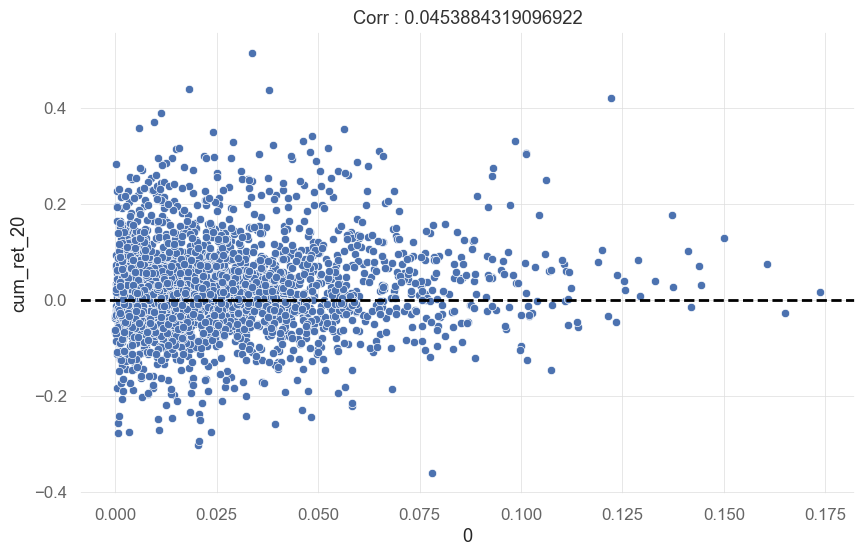

In [109]:
dual_ma = fast_ma - slow_ma

my_events = dual_ma[event_trigger].stack()
events_ret,events_cum_ret = get_event_ret_df(my_events,future_ret,future_cum_ret,if_skip=False)
sns.scatterplot(x = events_cum_ret[0], y = events_cum_ret['cum_ret_20'])
plt.title('Corr : {}'.format(events_cum_ret[0].corr(events_cum_ret['cum_ret_20'],method='spearman')))

# horizontal line indicating 0
plt.axhline(0, color='black', linestyle='--', lw=2)

In [110]:
start,end  = '2006-01-01', '2023-01-01'

fee = 0.001

event_position = event_trigger.astype(int).replace({0:np.nan}).fillna(method='ffill',limit=20)

event_stg = ((event_position*(ret-event_trigger.astype(int)*fee)).mean(axis=1)).fillna(ret.mean(axis=1))

pd.DataFrame(su.performance_stats(event_stg,bm_ret,period='daily',start=start, end = end),index=[0])

,annual_ret,ann_pre_ret,annual_vol,max_drawdown,sharpe_ratio,calmar_ratio,info_ratio,win_ratio
0,0.147194,0.047452,0.271482,-0.695732,0.642857,0.211566,0.032604,0.489541


Signal Count Per year and sector:0.55
# of tradeassets:  31


<Axes: xlabel='cum_ret_20', ylabel='Density'>

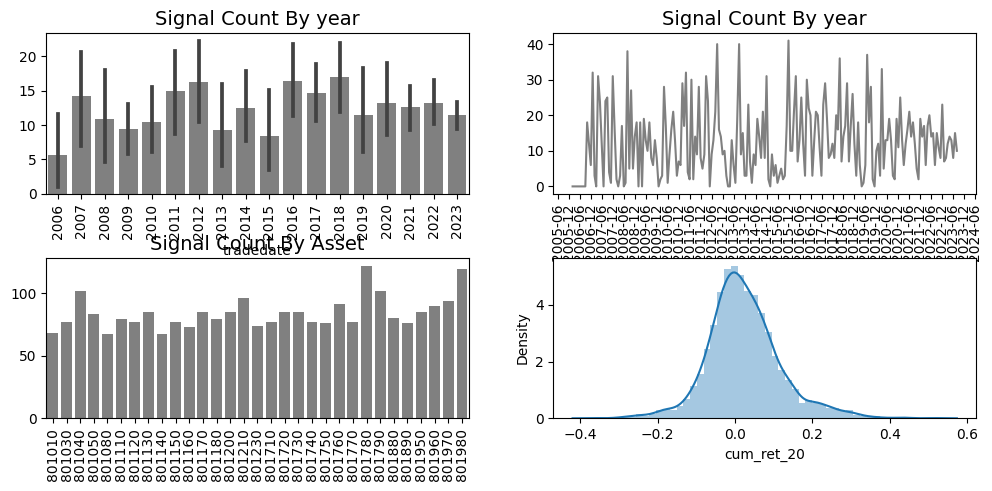

In [1519]:
print(f'Signal Count Per year and sector:{len(event_trigger)/len(tradeassets)/252:.2f}')
print('# of tradeassets: ',len(tradeassets))

fig,axes = plt.subplots(2,2,figsize=(12,5))

plt.subplots_adjust(hspace=0.4)

# Signal Count By year

ax = axes[0][0]
sig_count = event_trigger.astype(int).resample('M').sum().sum(axis=1)
sns.barplot(x=sig_count.index.strftime('%Y'), y=sig_count.values, ax=ax, color='grey')
plt.setp(ax.get_xticklabels(), rotation=90);
ax.set_title(f'Signal Count By year', fontsize=14,)

# Signal Count By year

ax = axes[0][1]
sig_count = event_trigger.astype(int).resample('M').sum().sum(axis=1)

sns.lineplot(x=sig_count.index, y=sig_count.values, ax=ax, color='grey')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax.get_xticklabels(), rotation=90);
ax.set_title(f'Signal Count By year', fontsize=14,)

# Signal Count By Sector
ax = axes[1][0]

sig_count = event_trigger.astype(int).resample('M').sum().sum(axis=0)

sns.barplot(x=sig_count.index, y=sig_count.values, ax=ax, color='grey')

# 可选的设置 x 轴刻度线格式和标签旋转
plt.setp(ax.get_xticklabels(), rotation=90);
ax.set_title(f'Signal Count By Asset', fontsize=14,)



# ax = axes[1][1]
# plot_ret(events_ret_isp,ax)
events_series = mb[event_trigger].stack().astype(float)
events_ret,events_cum_ret = get_event_ret_df(events_series,future_ret,future_cum_ret)
sns.distplot(events_cum_ret['cum_ret_20'])

Text(0.5, 1.0, 'Holding Period of 10 days')

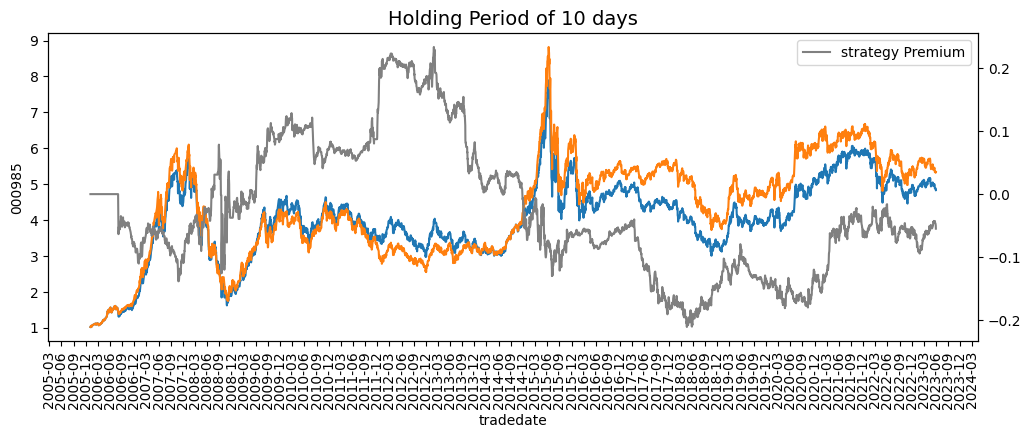

In [1231]:
start = '2006-01-01'
end = '2023-06-01'
event_net_val = (event_stg[start:end] +1).cumprod()
bm_net_val = (bm_ret[start:end]+1).cumprod()
pre_ret = (event_stg[start:end] - bm_ret[start:end]).cumsum()

fig,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(event_net_val,ax=ax)
sns.lineplot(bm_net_val,ax=ax)
sns.lineplot(pre_ret,ax=ax.twinx(),color='grey', label = 'strategy Premium')


ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax.get_xticklabels(), rotation=90);
ax.set_title(f'Holding Period of 10 days', fontsize=14,)

Text(0.5, 1.0, 'Out of Sample: 2016-01-01 to 2023-01-01')

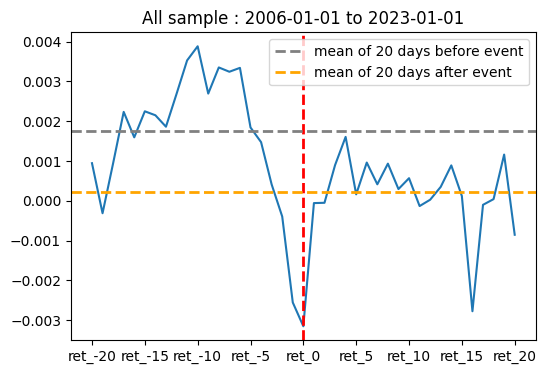

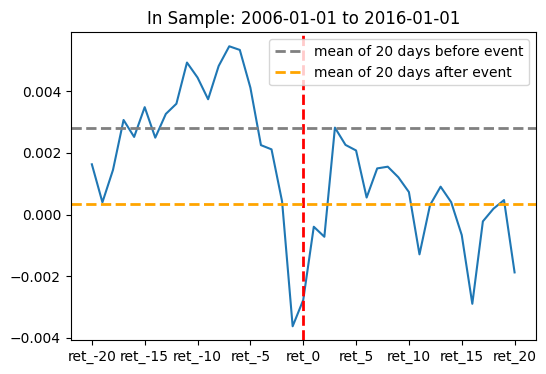

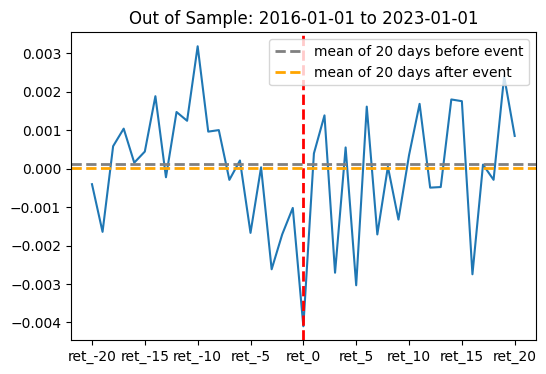

In [1230]:
# Trend following strategy based on market breadth
fig,ax = plt.subplots(1,1,figsize=(6,4))

start,end = '2006-01-01', '2023-01-01'


events_series = mb[event_trigger].stack().astype(float)
events_ret,events_cum_ret = get_event_ret_df(events_series,future_ret,future_cum_ret)

plot_ret(events_ret,ax)
ax.set_title(f'All sample : {start} to {end}')

## 
start,end = '2006-01-01', '2016-01-01'


fig,ax = plt.subplots(1,1,figsize=(6,4))

events_ret_isp , events_cum_ret_isp =  events_ret.unstack().loc[start:end].stack(), events_cum_ret.unstack().loc[start:end].stack()

plot_ret(events_ret_isp,ax)
ax.set_title(f'In Sample: {start} to {end}')

## 
start,end = '2016-01-01', '2023-01-01'

fig,ax = plt.subplots(1,1,figsize=(6,4))

events_ret_oop , events_cum_ret_oop =   events_ret.unstack().loc[start:end].stack(), events_cum_ret.unstack().loc[start:end].stack()

plot_ret(events_ret_oop,ax)
ax.set_title(f'Out of Sample: {start} to {end}')

Continuous timing

In [1389]:
event_sig = trigger.astype(int)
event_sig.replace(1,-1,inplace=True)

In [1392]:
pre_ret = ret.sub(bm_ret,axis=0)

In [1393]:
# # get the statistics of events strategy in sample
pre_corr_isp = get_corr(pre_ret.shift(-1),event_sig,isp=True)
corr_isp = get_corr(ret.shift(-1),event_sig,isp=True)
base_isp = get_corr(ret.shift(-1),ret.notna().astype(int),isp=True)

# get the statistics of events strategy out sample
pre_corr_oop = get_corr(pre_ret.shift(-1),event_sig,isp=False)
corr_oop = get_corr(ret.shift(-1),event_sig,isp=False)
base_oop = get_corr(ret.shift(-1),ret.notna().astype(int),isp=False)

stats_df = get_event_stats(events_cum_ret_isp)
display(stats_df)

stats_df = get_event_stats(events_cum_ret_oop)
display(stats_df)

my_corr_df = get_my_corr_df(pre_corr_isp, corr_isp, base_isp, pre_corr_oop, corr_oop, base_oop)

display(my_corr_df)

,before_ret,after_ret,diff,tval,long_win_ratio,short_win_ratio
1,-0.0036,-0.0004,0.0032,2.5627,0.5604,0.4178
5,0.0239,0.0058,-0.0182,-7.3687,0.5706,0.4294
10,0.0300,0.0116,-0.0184,-5.0119,0.6041,0.3959
20,0.0587,0.0069,-0.0519,-8.6395,0.5197,0.4803
60,0.1104,0.0474,-0.0629,-4.5713,0.5153,0.4847


,before_ret,after_ret,diff,tval,long_win_ratio,short_win_ratio
1,-0.0010,0.0004,0.0014,1.1239,0.4701,0.5100
5,0.0002,-0.0033,-0.0035,-1.5106,0.4900,0.5100
10,0.0080,-0.0043,-0.0123,-3.5058,0.4652,0.5348
20,0.0033,0.0010,-0.0023,-0.4196,0.5075,0.4925
60,-0.0208,0.0123,0.0331,3.4879,0.5124,0.4876


,pre_corr_isp,corr_isp,base_isp,pre_corr_oop,corr_oop,base_oop
corr,-0.060238,0.029668,-0.025355,0.011248,-0.001053,NaN
ann_ret,-0.015635,-0.054597,0.134183,-0.007586,-0.029448,0.005119
sharpe,-0.286616,-0.158462,0.573443,-0.147292,-0.178607,0.122635
calmar,-0.084712,-0.109108,0.185583,-0.038148,-0.073530,0.012932
max_dd,-0.184562,-0.500390,-0.723038,-0.198850,-0.400492,-0.395855
win_ratio_day,0.539745,0.481845,0.543245,0.521674,0.485800,0.516735


<Axes: >

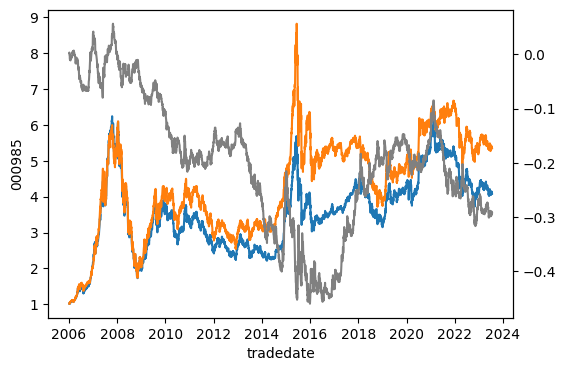

In [1387]:

event_net_val = (event_stg[start:end] +1).cumprod()
bm_net_val = (bm_ret[start:end]+1).cumprod()
pre_ret = (event_stg[start:end] - bm_ret[start:end]).cumsum()

fig,ax = plt.subplots(1,1,figsize=(6,4))
sns.lineplot(event_net_val,ax=ax)
sns.lineplot(bm_net_val,ax=ax)
sns.lineplot(pre_ret,ax=ax.twinx(),color='grey')

In [720]:
from matplotlib import dates as mdates

In [1213]:
len(event_trigger)/31/17

8.08728652751423

801010


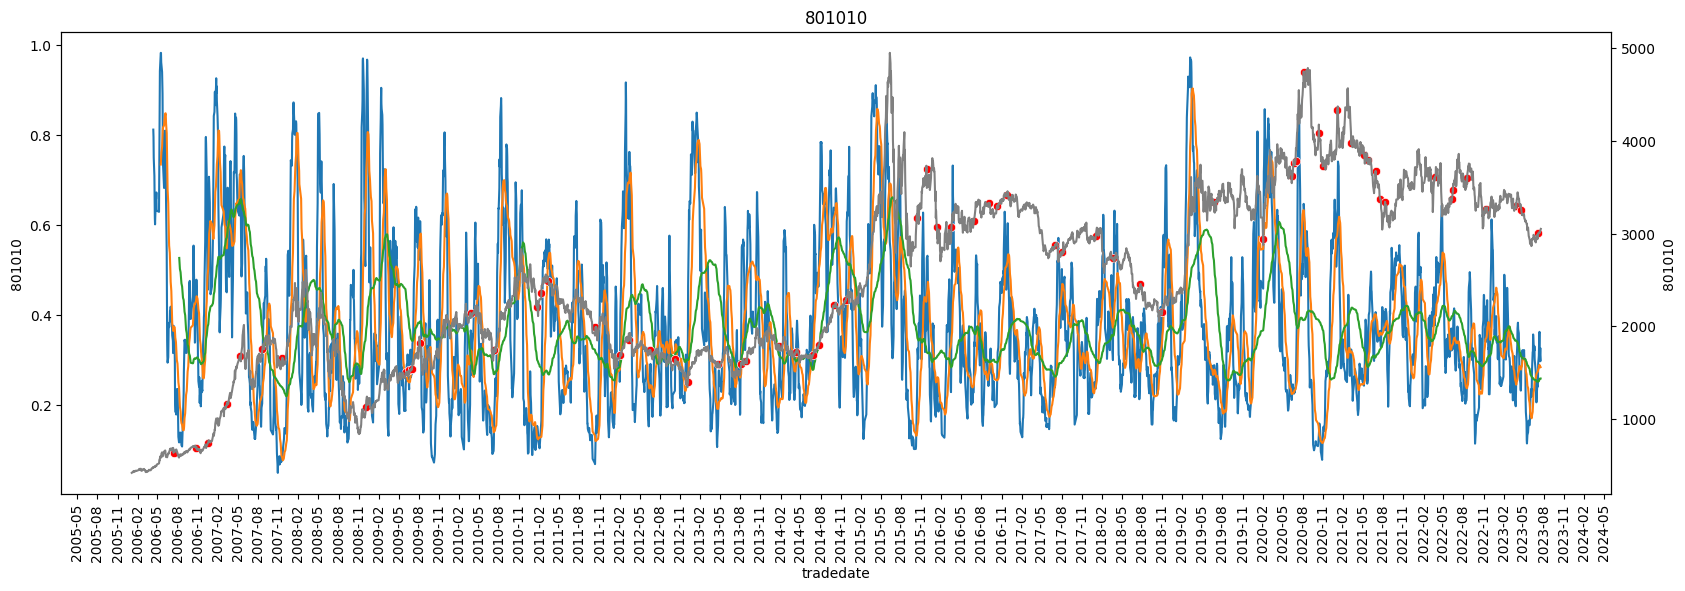

In [1559]:

pre_prices = (1+pre_ret).cumprod()


for symbol in event_trigger.columns:
    print(symbol)
    fig,ax = plt.subplots(figsize=(20,6))
    
    start,end = '2006-01-01','2024-01-01'
    sns.lineplot(fast_ma[symbol][start:end],ax=ax)
    sns.lineplot(slow_ma[symbol][start:end],ax=ax)
    sns.lineplot(fast_ma.rolling(80).mean()[symbol][start:end],ax=ax)
    # sns.lineplot(dual_ma.rolling(252*5).rank(pct=True)[symbol][start:end],ax=ax)

    # sns.lineplot(fast_ma.diff().rolling(252*5).rank(pct=True)[symbol][start:end],ax=ax)
    # sns.lineplot(slow_ma.diff().rolling(252*3).rank(pct=True)[symbol][start:end],ax=ax)

    ax2 = ax.twinx()

    sns.lineplot(prices[symbol][start:end],ax=ax2,color='grey')
    sns.scatterplot(event_trigger[symbol].astype(int).replace({0:np.nan})*prices[symbol][start:end],ax=ax2,color='red')



    ax.set_title(symbol)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    # rotate x label 90
    plt.setp(ax.get_xticklabels(), rotation=90);
    # plt.savefig(f'../time_stg/{symbol}_result.png')
    # import mdates
    break

In [1412]:
# rolling_prod = (1+ret).rolling(60).apply(lambda x:np.prod(x)-1)
# rolling_prod = rolling_prod['2016-01-01':]
# pd.concat([rolling_prod.idxmax(),rolling_prod.max()],axis=1).sort_index()